# Histology Demo with Intel® Distribution of OpenVINO™ Toolkit. 

## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    
    - **histology.ipynb** - This Jupyter* Notebook
    - **data** - Directory to hold data
    - **python** -Directory for the Python scripts

## Introduction

This demo uses the [colorectal histology images dataset](https://www.tensorflow.org/datasets/catalog/colorectal_histology) to train a simple convolutional neural network in TensorFlow and demonstrates how to use OpenVINO™ integration with Tensorflow and OpenVINO™ Inference Engine to do inference on different Hardware architecture.

All images are RGB, 0.495 µm per pixel, digitized with an Aperio ScanScope (Aperio/Leica biosystems), magnification 20x. Histological samples are fully anonymized images of formalin-fixed paraffin-embedded human colorectal adenocarcinomas (primary tumors) from our pathology archive (Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany).

The model is trained using the histology model introduced here: [Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F: Multi-class texture analysis in colorectal cancer histology (2016), Scientific Reports (in press)] (https://zenodo.org/record/53169#.X_T3iC1h10v)



### Key concepts
This sample application includes an example for the following:
- Application:
  - Load and visualize Tensorflow dataset
- Intel® DevCloud for the Edge: submitting jobs to perform on different edge compute nodes (rather than on the development node hosting this Jupyter* notebook)
  - Training jobs that train a convolutional neural network with Tensorflow V2
  - Running inference jobs with OpenVINO™ integration with Tensorflow
  - Running Inference jobs with OpenVINO™ Inference Engine
  - Monitoring job status
  - Viewing results and assessing performance for hardware on different compute nodes
- [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/openvino-toolkit):
  - Create the necessary Intermediate Representation (IR) files for the inference model using [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html)
  - Run an inference application on multiple hardware devices using the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow_datasets as tfds

print(tf.__version__)

2.7.0


In [2]:
from platform import python_version
print(python_version())

3.7.11


 ### Dataset Examples
 #### How to load TF colorrectal_histology dataset

In [3]:
os.environ['NO_GCE_CHECK'] = 'true'

In [4]:
(ds), ds_info =  tfds.load('colorectal_histology', data_dir=".", 
                                          shuffle_files=True, split='train', 
                                          with_info=True, as_supervised=True)

assert isinstance(ds, tf.data.Dataset)
print(ds_info)

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_path='./colorectal_histology/2.0.0',
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melcher

#### Display a few examples from the dataset

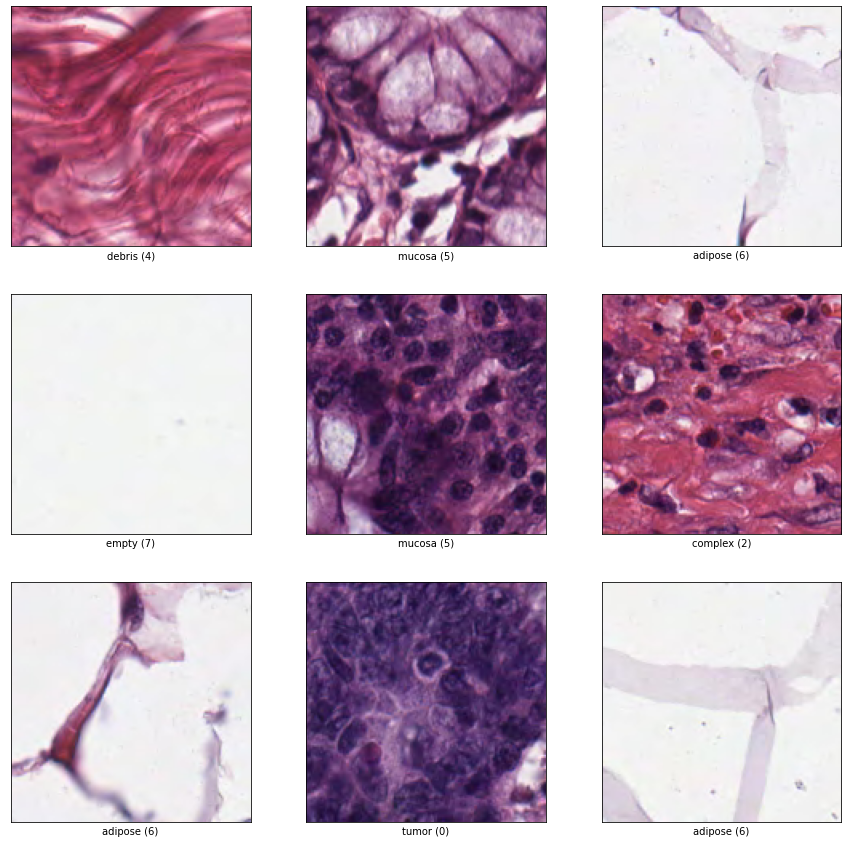

In [5]:
x_key, y_key = ds_info.supervised_keys
ds_temp = ds.map(lambda x, y: {x_key: x, y_key: y})
tfds.show_examples(ds_temp, ds_info, plot_scale=5);
!mkdir -p test_data

#### Check the histology classification subtypes

In [6]:
ds_info.features['label'].names

['tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty']

## Histology Demo
The Histology demo uses the Intel® Optimized Tensorflow to perform training and inference on input color rectal histology image dataset using OpenVINO™ integration with Tensorflow and Intel® Distribution of OpenVINO™ toolkit .  We will setup, train, run, and view the results for this application for several different hardware available on the compute nodes within the Intel® DevCloud for the Edge.  To accomplish this, we will be performing the following tasks:

1. Train the model in [Intel Optimized Tensorflow](https://software.intel.com/content/www/us/en/develop/tools/frameworks.html)
1. Run Inference using [OpenVINO™ Integration with Tensorflow](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/build/ovtfoverview.html)
2. Use the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to create the inference model IR files needed to perform inference
3. Create the job file used to submit running training and inference on compute nodes
4. View results and assess performance 

### How it works
At startup, for both training and inference, the Histology application configures itself by parsing the command line arguments. Once configured, the training application loads the specified input dataset, prepares the data accordingly and runs training on the specified edge compute node. Once the model is trained, the inference app loads the inference model's IR files into the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and runs inference on the specified input data to find the class of the given histology image. After the specific job is completed, the output is stored in the appropriate `results/<architecture>/` directory.  

The following sections will guide you through configuring and running the Histology demo.

### Model training for the histology images
The following sections will go through the steps to run training on the current EC2 instance. 

#### Create the job file

The job file is a [Bash](https://www.gnu.org/software/bash/) script that serves as a wrapper around the Python* executable of our application that can be executed directly on different types of edge compute node.  One purpose of the job file is to simplify running an application on different compute nodes by accepting a few arguments and then performing accordingly any necessary steps before and after running the application executable.  

For this sample, the job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
training_job.sh <output_directory> <input_directory> <epochs> <device> <num_cores>
```
Where the job file input arguments are:
- <*output_directory*> - Output directory to use to store output files
- <*input_directory*> - Path to the input training data
- <*epochs*> - Epochs to train the model
- <*device*> - Specify the device used for training
- <*num_cores*> - If device is CPU, need to specify number of physical cores on the targeted device

Based on the input arguments, the job file will do the following:
- Change to the working directory `PBS_O_WORKDIR` where this Jupyter* Notebook and other files appear on the compute node
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments

Run the following cell to create the `training_job.sh` job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `training_job.sh`.

In [7]:
%%writefile training_job.sh

# Store input arguments: <output_directory> <input_directory>
INPUT_DIRECTORY=$1
OUTPUT_DIRECTORY=$2
EPOCHS=$3
DEVICE=$4
CORES=$5

# The default path for the job is the user's home directory,
#  change directory to where the files are.
if [ ! -d "./results/" ];then
   mkdir -p "./results"
fi
# Make sure that the output directory exists.
mkdir -p "$OUTPUT_DIRECTORY"

# Install Tensorflow 
python python/run_training.py -i $INPUT_DIRECTORY \
                               -o $OUTPUT_DIRECTORY \
                               -e $EPOCHS \
                               -d $DEVICE \
                               -c $CORES


Overwriting training_job.sh


#### [OPTIONAL FOR ISBI DEMO] Submit training job

In [8]:
# ! bash ./training_job.sh colorectal_histology results/xeon/ice_lake 25 CPU 48

2022-03-25 05:29:55.430595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 05:29:55.430621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
TensorFlow version = 2.7.0
Imported Python modules successfully.
Start training
[ INFO ] Set OMP parameters
[ INFO ] Getting data
[ INFO ] Load dataset info from ./colorectal_histology/2.0.0
[ INFO ] Reusing dataset colorectal_histology (./colorectal_histology/2.0.0)
[ INFO ] Constructing tf.data.Dataset colorectal_histology for split train, from ./colorectal_histology/2.0.0
2022-03-25 05:29:57.366702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: canno

#### Trained model
Once the training job has completed, the queue system outputs the stdout and stderr streams, respecitvely.

The generated model file is written to the directory `results/<device>/checkpoints` that was specified as the output directory to the job file.  

<br><div class=danger><b>Wait!: </b>Please wait for the training job to complete before proceeding to the next step to do the OpenVINO™ model conversion and inferencing with OpenVINO™.</div>

### Inference using OpenVINO™ Integration with Tensorflow and OpenVINO™ Inference Engine
The following sections will go through the steps to run inference application for a single image using OpenVINO integration with Tensorflow and if dataset on OpenVINO Inference Engine. For viewing the results from job please refer to section 4.5

#### Inference job for single image using OpenVINO™ Integration with Tensorflow

##### Create the job file
Similarly to the training, we will run inference using OpenVINO™ integration with Tensorflow for single image.

The inference job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
run_tensorflow_openvino.sh <device> 
```

Where the job file input arguments are:
- <*device*> - Specify the device used for inferencing

classification_ovtf_histology.py takes in multiple arguments as listed below
 - m "histology_model"
 - i "input_layer of the model>"
 - o "input_layer of the model>"
 - ip "image in Jpeg format"
 - l "label map file"
                  

Based on the input arguments, the job file will do the following:
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments



In [9]:
%%writefile run_tensorflow_openvino.sh

#!/bin/sh

DEVICE=$1

python python/classification_ovtf_histology.py -m "./results/xeon/ice_lake/frozen_histology.pb" \
                       -i "x" \
                       -o "Identity" \
                       -ip "./data/A8D0_CRC-Prim-HE-10_002c.tif_Row_1_Col_451.jpg" \
                       -it "image" \
                       -l "./data/labels_histology.txt" \
                       -f "openvino" \
                       --input_height 150 \
                       --input_width 150 \
                       --input_mean 3 \
                       -d $DEVICE 

Overwriting run_tensorflow_openvino.sh


##### Submit  Inference job using OpenVINO™ Integration with Tensorflow
 
The inference workload will run on the CPU. It can be modified to schedule on another accelerator by passing the flag F as with a value of GPU, VPU, or VAD-M.
 
The workload images are expected to be in JPEG format. Any custom inputs need to be converted to JPEG before performing inference on them.

In [10]:
!chmod +x ./run_tensorflow_openvino.sh
! bash ./run_tensorflow_openvino.sh "CPU"

2022-03-25 05:56:44.706036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 05:56:44.706064: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Available Backends:
CPU
2022-03-25 05:56:46.021944: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 05:56:46.024003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot op

#### Convert the Tensorflow model to OpenVINO IR files
This workload is run on the CPU.

Run the following cell for Model Optimizer to create the model IR files. It converts the saved model trained from an edge Xeon Cascade Lake node to OpenVINO™ model format and saves it under `models/ov/<Model Precision>`. The model conversion can use either the generated savedModel or the frozen tensorflow model. Below mo_convert.sh script supports both model formats 

In [11]:
input_model="saved_model" 

In [12]:
!source mo_convert.sh $input_model 2>/dev/null | grep SUCCESS

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /home/ubuntu/histology/models/ov/FP32/saved_model.xml
[ SUCCESS ] BIN file: /home/ubuntu/histology/models/ov/FP32/saved_model.bin
[ SUCCESS ] Total execution time: 5.93 seconds. 
[ SUCCESS ] Memory consumed: 1131 MB. 


In [13]:
input_model="frozen_model" 

In [14]:
!source mo_convert.sh $input_model | grep SUCCESS

2022-03-25 05:57:39.319892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 05:57:39.319925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/ubuntu/anaconda3/envs/histology_demo/lib/python3.7/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /home/ubuntu/histology/models/ov/FP32/frozen_histology.xml
[ SUCCESS ] BIN file: /home/ubuntu/histology/models/ov/FP32/frozen_histology.bin
[ SUCCESS ] Total execution time: 4.39 seconds. 
[ SUCCESS ] Memory consumed: 688 MB. 


In [15]:
!echo "\nAll IR files that were created:"
!find ./models/ov/FP32 -name "*.xml" -o -name "*.bin"

\nAll IR files that were created:
./models/ov/FP32/frozen_histology.bin
./models/ov/FP32/frozen_histology.xml
./models/ov/FP32/saved_model.bin
./models/ov/FP32/saved_model.xml


#### Run inference on Histology Dataset via OpenVINO™ Inference Engine
The following sections will go through the steps to run our inference application for the Histology dataset. 

##### Create the job file
Similarly to the training, we will run inference on this EC2 instance node.

The inference job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format:
```bash
inference_job.sh <model_directory> <input_directory> <output_directory> <device>
```
Where the job file input arguments are:
- <*model_directory*> - OpenVINO™ model directory
- <*input_directory*> - Path to the input testing data
- <*output_directory*> - Path to store the inference output
- <*device*> - Specify the device used for inferencing

Based on the input arguments, the job file will do the following:
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments

Run the following cell to create the `inference_job.sh` job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `inference_job.sh`.

In [16]:
%%writefile inference_job.sh

# Store input arguments: <model_type> <input_directory> <output_directory> <device>
MODEL_TYPE=$1
INPUT_DIRECTORY=$2
OUTPUT_DIRECTORY=$3
DEVICE=$4

# Make sure that the output directory exists.
mkdir -p "$OUTPUT_DIRECTORY"
mkdir -p "$OUTPUT_DIRECTORY$MODEL_TYPE"

# Run the inference code
python python/run_inference.py -d $DEVICE \
                                -i $INPUT_DIRECTORY \
                                -o $OUTPUT_DIRECTORY$MODEL_TYPE \
                                -m $MODEL_TYPE

Overwriting inference_job.sh


##### Run inference
In the cell below, we run the inference workload .

In [17]:
! chmod +x ./inference_job.sh
! bash ./inference_job.sh FP32 test_data/testdata.npz results/xeon/ice_lake/ CPU

2022-03-25 05:57:44.508985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 05:57:44.509013: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Imported Python modules successfully.
{'device': 'CPU', 'input_data': 'test_data/testdata.npz', 'model': 'FP32', 'output': 'results/xeon/ice_lake/FP32', 'num_instance': '1'}
[ INFO ] Creating Inference Engine
[ INFO ] Reading data from test_data/testdata.npz
[ INFO ] Loading network:
	FP32
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
[ INFO ] Write the prediction into the results/xeon/ice_lake/FP32/stats.txt file.


In [18]:
!find "results/xeon/ice_lake/FP32" -name "stats.txt"

results/xeon/ice_lake/FP32/stats.txt


## Quantization

Quantization is the process of reducing the model's precision. By performing this optimization, you can accelerate your model execution time.  

The [quantize.py](python/quantize.py) file contains quantization script and uses the [post training optimization toolkit (POT) API](https://docs.openvinotoolkit.org/latest/pot_compression_api_README.html) to reduce model's precision from FP32 to INT8. Quantization settings, such as the path to original model, path to dataset, quantization algorithm etc., which should be set via configs. ```DatasetsDataLoader``` creates quantization dataset from the sample video and loads one by one input images to POT, when quantization process starts. When quantization is finished, the INT8 model will be saved at ```'/models/ov/INT8'``` directory.

Run the following cell to create the ```quantization_job.sh``` job file. This script runs quantization and benchmarking of the quantized and non-quantized models to compare their execution time.

Write the Tensorflow inference scripts to do benchmarking. 

In [19]:
%%writefile run_tensorflow_inference.sh

#!/bin/sh

DEVICE=$1

python python/classification_ovtf_histology.py -m "./results/xeon/ice_lake/frozen_histology.pb" \
                       -i "x" \
                       -o "Identity" \
                       -ip "./data/A8D0_CRC-Prim-HE-10_002c.tif_Row_1_Col_451.jpg" \
                       -it "image" \
                       -l "./data/labels_histology.txt" \
                       -f "native" \
                       --input_height 150 \
                       --input_width 150 \
                       --input_mean 3 \
                       -d $DEVICE \
                       -nite 20

python python/classification_ovtf_histology.py -m "./results/xeon/ice_lake/frozen_histology.pb" \
                       -i "x" \
                       -o "Identity" \
                       -ip "./data/A8D0_CRC-Prim-HE-10_002c.tif_Row_1_Col_451.jpg" \
                       -it "image" \
                       -l "./data/labels_histology.txt" \
                       -f "oneDNN" \
                       --input_height 150 \
                       --input_width 150 \
                       --input_mean 3 \
                       -d $DEVICE \
                       -nite 20

python python/classification_ovtf_histology.py -m "./results/xeon/ice_lake/frozen_histology.pb" \
                       -i "x" \
                       -o "Identity" \
                       -ip "./data/A8D0_CRC-Prim-HE-10_002c.tif_Row_1_Col_451.jpg" \
                       -it "image" \
                       -l "./data/labels_histology.txt" \
                       -f "openvino" \
                       --input_height 150 \
                       --input_width 150 \
                       --input_mean 3 \
                       -d $DEVICE \
                       -nite 20

Overwriting run_tensorflow_inference.sh


In [20]:
%%writefile quantization_job.sh

# Run the quantization script
python ./python/quantize.py

# Run the benchmark for Tensorflow model with Stock Tensorflow, oneDNN and OpenVINO integration with Tensorflow
./run_tensorflow_inference.sh CPU 2>/dev/null | grep "Throughput" 

# Run the benchmark_app for FP32 model
benchmark_app \
        -m ./models/ov/FP32/saved_model.xml 2>/dev/null | grep Throughput | xargs echo FP32

# Run the benchmark_app for INT8 model
benchmark_app \
        -m ./models/ov/INT8/saved_model.xml 2>/dev/null | grep Throughput | xargs echo INT8



Overwriting quantization_job.sh


Run the following cell to start quantization and benchmarking of the quantized model.

In [21]:
import os
import time

In [22]:
def wait_for_job_to_finish(job_id):
    if job_id:
        print("Job submitted to the queue. Waiting for it to complete.")    
                    
        # Reading the benchmark_app results
        print('Results for FP32 and INT8 models:')
        for line in job_id:            
            if 'Throughput' in line:
                print(line.split('\n')[0])
    else:
        print("Error in job submission.")

job_id_core = get_ipython().getoutput('bash ./quantization_job.sh')
benchmarks = wait_for_job_to_finish(job_id_core)

Job submitted to the queue. Waiting for it to complete.
Results for FP32 and INT8 models:
Throughput for using native Tensorflow: 83.91 FPS
Throughput for using oneDNN Tensorflow: 72.53 FPS
Throughput for using openvino Tensorflow: 269.25 FPS
FP32 Throughput: 407.30 FPS
INT8 Throughput: 1901.40 FPS


### Inferencing accuracy comparison between FP32 model and INT8 model

The output classification results for each job is written to the file `stats_<*job id*>.txt` located in the directory `results/<device>` that was specified as the output directory to the job file. Each line of the result txt file records the following information:

`index of the testing image, true class label, predicted class label`

Example of how to view the inferencing results are shown below. The overall accuracy is also shown below. 


In [23]:
! chmod +x ./inference_job.sh
! bash ./inference_job.sh INT8 test_data/testdata.npz results/xeon/ice_lake/ CPU

2022-03-25 06:00:15.426449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/anaconda3/envs/histology_demo/lib/:
2022-03-25 06:00:15.426476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Imported Python modules successfully.
{'device': 'CPU', 'input_data': 'test_data/testdata.npz', 'model': 'INT8', 'output': 'results/xeon/ice_lake/INT8', 'num_instance': '1'}
[ INFO ] Creating Inference Engine
[ INFO ] Reading data from test_data/testdata.npz
[ INFO ] Loading network:
	INT8
[ INFO ] Preparing input blobs
[ INFO ] Loading model to the plugin
[ INFO ] Write the prediction into the results/xeon/ice_lake/INT8/stats.txt file.


In [24]:
#For viewing accuracy
def calc_accuracy(result_file, precision):
    with open(result_file, 'r') as f:
        preds = f.readlines()
        count = len(preds)
        true_count = 0
        for line in preds:
            line=line.rstrip().split(",")
            if line[1] == line[2]:
                true_count += 1
    print("Accuracy of the {0} model is {1:.4f}.".format(precision, true_count*1.0/count))

calc_accuracy("results/xeon/ice_lake/FP32/stats.txt", "FP32")    
calc_accuracy("results/xeon/ice_lake/INT8/stats.txt", "INT8")

Accuracy of the FP32 model is 0.8320.
Accuracy of the INT8 model is 0.8300.
